# Methodology

In this page, we'll walk through step-by-step the process we use to create PolicyEngine's dataset.
* **Family Resources Survey**: we'll start with the FRS, looking at close it is to reality. To take an actual concrete starting point, we'll assume benefit payments are as reported in the survey.
* **FRS (+ tax-benefit model)**: we need to make sure that our tax-benefit model isn't doing anything unexpected. If we turn on simulation of taxes and benefits, does anything look unexpected? If not- great, we've turned a household survey into something useful for policy analysis. We'll also take stock here of what we're missing from reality.
* **Wealth and consumption**: the most obvious thing we're missing is wealth and consumption. We'll impute those here.
* **Fine-tuning**: we'll use reweighting to make some final adjustments to make sure our dataset is as close to reality as possible.
* **Validation**: we'll compare our dataset to the UK's official statistics, and see how we're doing.

## The Family Resources Survey

First, we'll start with the FRS as-is. Skipping over the technical details for how we actually feed this data into the model (you can find that in `policyengine_uk_data/datasets/frs/`), we need to decide how we're actually going to measure 'close to reality'. We need to define an objective function, and if our final dataset improves it a lot, we can call that a success.
         
We'll define this objective function using public statistics that we can generally agree are of high importance to describing the UK household sector. These are things that, if the survey gets them wrong, we'd expect to cause inaccuracy in our model, and if we get them all mostly right, we'd expect to have confidence that it's a pretty accurate tax-benefit model.
         
For this, we've gone through and collected:
         
* **Demographics** from the ONS: ten-year age band populations by region of the UK, national family type populations and national tenure type populations.
* **Incomes** from HMRC: for each of 14 total income bands, the number of people with income and combined income of the seven income types that account for over 99% of total income: employment, self-employment, State Pension, private pension, property, savings interest, and dividends.
* **Tax-benefit programs** from the DWP and OBR: statistics on caseloads, expenditures and revenues for all 20 major tax-benefit programs.
         
Let's first take a look at the initial FRS, our starting point, and what is generally considered the best dataset to use (mostly completely un-modified across major tax-benefit models), and see how close it is to reproducing these statistics.
         
The table below shows the result, and: it's really quite bad! Look at the relative errors.




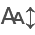

name      estimate  \
0                             obr/attendance_allowance  3.733651e+09   
1                                 obr/carers_allowance  2.882300e+09   
2                                              obr/dla  4.081635e+09   
3                                              obr/esa  7.209292e+09   
4                                      obr/esa_contrib  1.777680e+09   
..                                                 ...           ...   
330  hmrc/property_income_count_income_band_13_12_5...  1.632946e+06   
331  hmrc/savings_interest_income_income_band_13_12...  4.510452e+09   
332  hmrc/savings_interest_income_count_income_band...  1.416795e+07   
333  hmrc/dividend_income_income_band_13_12_570.0_t...  7.626864e+09   
334  hmrc/dividend_income_count_income_band_13_12_5...  2.521638e+06   

           target         error     abs_error  rel_error  abs_rel_error  \
0    5.700000e+09 -1.966349e+09  1.966349e+09  -0.344974       0.344974   
1    3.300000e+09 -4.176997e+08  4.176997e+08  -0.126576       0.126576   
2    6.000000e+09 -1.918365e+09  1.918365e+09  -0.319728       0.319728   
3    1.210000e+10 -4.890708e+09  4.890708e+09  -0.404191       0.404191   
4    4.500000e+09 -2.722320e+09  2.722320e+09  -0.604960       0.604960   
..            ...           ...           ...        ...            ...   
330  2.320606e+06 -6.876600e+05  6.876600e+05  -0.296328       0.296328   
331  2.968650e+09  1.541802e+09  1.541802e+09   0.519361       0.519361   
332  1.154405e+07  2.623900e+06  2.623900e+06   0.227295       0.227295   
333  8.579240e+10 -7.816554e+10  7.816554e+10  -0.911101       0.911101   
334  3.936170e+06 -1.414532e+06  1.414532e+06  -0.359368       0.359368   

            type  
0    Tax-benefit  
1    Tax-benefit  
2    Tax-benefit  
3    Tax-benefit  
4    Tax-benefit  
..           ...  
330       Income  
331       Income  
332       Income  
333       Income  
334       Income  

[335 rows x 8 columns]

In [2]:
from policyengine_uk_data.utils import get_loss_results
from policyengine_uk_data import (
    FRS_2022_23,
    ExtendedFRS_2022_23,
    EnhancedFRS_2022_23,
    ReweightedFRS_2022_23,
)
from policyengine_core.model_api import Reform
import plotly.express as px
import pandas as pd
from itables import init_notebook_mode
import itables.options as opt
opt.maxBytes = "1MB"

init_notebook_mode(all_interactive=True)

def get_loss(dataset, reform, time_period):
    loss_results = get_loss_results(dataset, time_period, reform)

    def get_type(name):
        if "hmrc" in name:
            return "Income"
        if "ons" in name:
            return "Demographics"
        if "obr" in name:
            return "Tax-benefit"
        return "Other"

    loss_results["type"] = loss_results.name.apply(get_type)
    return loss_results

reported_benefits = Reform.from_dict(
    {
        "gov.contrib.policyengine.disable_simulated_benefits": True,
    }
)
loss_results = get_loss(
    dataset=FRS_2022_23, reform=reported_benefits, time_period=2022
).copy()

loss_results

It's easier to understand 'what kind of bad' this is by splitting out the statistics into those three categories. Here's a histogram of the absolute relative errors.

In [5]:
from policyengine.utils.charts import *
add_fonts()

In [7]:
fig = px.histogram(
    loss_results,
    x="abs_rel_error",
    nbins=25,
    title="Distribution of absolute relative errors",
    labels={
        "value": "Absolute relative error",
        "count": "Number of variables",
    },
    color="type",
    color_discrete_sequence=px.colors.qualitative.T10,
).update_layout(
    legend_title="Category",
    xaxis_title="Absolute relative error",
    yaxis_title="Number of variables",
    xaxis_tickformat=".0%",)
format_fig(fig)

A few notes:
         
* We're comparing things in the same relevant time period (2022), and only doing a tiny amount of adjustment to the statistics: OBR statistics are taken directly from the latest EFO, ONS statistics are the most recent projections for 2022, and HMRC statistics are uprated from 2021 to 2022 using the same standard uprating factors we use in the model (and it's only one year adjustment).
* Demogaphics look basically fine: that's expected, because the DWP applies an optimisation algorithm to optimise the household weights to be as close as possible to a similar set of demographic statistics. It's a good sign that we use slightly different statistics than it was trained on and get good accuracy.
* Incomes look *not great at all*. We'll take a closer look below to understand why. But the FRS is well-known to under-report income significantly.
* Tax-benefit programs also look *not good*. And this is a concern! Because we're using this dataset to answer questions about tax-benefit programs, and the FRS isn't even providing a good representation of them under baseline law.


In [ ]:
incomes = loss_results[loss_results.type == "Income"]
incomes["band"] = incomes.name.apply(
    lambda x: "_".join(x.split("band_")[1].split("_")[1:])
)
incomes["count"] = incomes.name.apply(lambda x: "count" in x)
incomes["variable"] = incomes.name.apply(
    lambda x: x.split("_income_band")[0].split("_count")[0].split("hmrc/")[-1]
)

variable = "employment_income"
count = True
variable_df = incomes[
    (incomes.variable == variable) & (incomes["count"] == count)
]

fig = px.bar(
    variable_df,
    x="band",
    y=[
        "target",
        "estimate",
        "error",
        "rel_error",
        "abs_error",
        "abs_rel_error",
    ],
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.T10,
)

fig = fig.update_layout(
    title="Estimates and ground truth for employment income band counts",
    xaxis_title="",
    yaxis_title="Value",
    legend_title="Variable",
)
format_fig(fig)

In [19]:
variable = "dividend_income"
count = True
variable_df = incomes[
    (incomes.variable == variable) & (incomes["count"] == count)
]

fig = px.bar(
    variable_df,
    x="band",
    y=[
        "target",
        "estimate",
        "error",
        "rel_error",
        "abs_error",
        "abs_rel_error",
    ],
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.T10,
)

fig = fig.update_layout(
    title="Estimates and ground truth for dividend income band counts",
    xaxis_title="",
    yaxis_title="Value",
    legend_title="Variable",
)
format_fig(fig)

There are a few interesting things here:
             
* The FRS over-estimates incomes in the upper-middle of the distribution and under-estimates them in the top of the distribution. The reason for this is probably: the FRS misses out the top completely, and then because of the weight optimisation (which scales up the working-age age groups to hit their population targets), the middle of the distribution is inflated, overcompensating.
* Some income types are severely under-estimated across all bands: notably capital incomes. This probably reflects issues with the survey questionnaire design more than sampling bias.

OK, so what can we do about it?

## Simulating benefits

First, let's turn on the model and check nothing unexpected happens. The table below shows each of our known statistics, and how they changed after replacing reported benefits with simulated benefits.

In [5]:
original_frs_loss = loss_results.copy()
frs_loss = get_loss(FRS_2022_23, None, 2022).copy()
combined_frs_loss = pd.merge(
    on="name",
    left=original_frs_loss,
    right=frs_loss,
    suffixes=("_original", "_simulated"),
)
combined_frs_loss["change_in_abs_rel_error"] = (
    combined_frs_loss["abs_rel_error_simulated"]
    - combined_frs_loss["abs_rel_error_original"]
)
# Sort columns
combined_frs_loss.sort_index(axis=1, inplace=True)
combined_frs_loss = combined_frs_loss.set_index("name")

combined_frs_loss

abs_error_original  \
name                                                                     
obr/attendance_allowance                                  1.966349e+09   
obr/carers_allowance                                      4.176997e+08   
obr/dla                                                   1.918365e+09   
obr/esa                                                   4.890708e+09   
obr/esa_contrib                                           2.722320e+09   
...                                                                ...   
hmrc/property_income_count_income_band_13_12_57...        6.876600e+05   
hmrc/savings_interest_income_income_band_13_12_...        1.541802e+09   
hmrc/savings_interest_income_count_income_band_...        2.623900e+06   
hmrc/dividend_income_income_band_13_12_570.0_to...        7.816554e+10   
hmrc/dividend_income_count_income_band_13_12_57...        1.414532e+06   

                                                    abs_error_simulated  \
name                                                                      
obr/attendance_allowance                                   2.079068e+09   
obr/carers_allowance                                       4.909088e+08   
obr/dla                                                    2.110043e+09   
obr/esa                                                    4.890708e+09   
obr/esa_contrib                                            2.722320e+09   
...                                                                 ...   
hmrc/property_income_count_income_band_13_12_57...         6.844470e+05   
hmrc/savings_interest_income_income_band_13_12_...         1.551142e+09   
hmrc/savings_interest_income_count_income_band_...         2.674657e+06   
hmrc/dividend_income_income_band_13_12_570.0_to...         7.815806e+10   
hmrc/dividend_income_count_income_band_13_12_57...         1.410788e+06   

                                                    abs_rel_error_original  \
name                                                                         
obr/attendance_allowance                                          0.344974   
obr/carers_allowance                                              0.126576   
obr/dla                                                           0.319728   
obr/esa                                                           0.404191   
obr/esa_contrib                                                   0.604960   
...                                                                    ...   
hmrc/property_income_count_income_band_13_12_57...                0.296328   
hmrc/savings_interest_income_income_band_13_12_...                0.519361   
hmrc/savings_interest_income_count_income_band_...                0.227295   
hmrc/dividend_income_income_band_13_12_570.0_to...                0.911101   
hmrc/dividend_income_count_income_band_13_12_57...                0.359368   

                                                    abs_rel_error_simulated  \
name                                                                          
obr/attendance_allowance                                           0.364749   
obr/carers_allowance                                               0.148760   
obr/dla                                                            0.351674   
obr/esa                                                            0.404191   
obr/esa_contrib                                                    0.604960   
...                                                                     ...   
hmrc/property_income_count_income_band_13_12_57...                 0.294943   
hmrc/savings_interest_income_income_band_13_12_...                 0.522508   
hmrc/savings_interest_income_count_income_band_...                 0.231691   
hmrc/dividend_income_income_band_13_12_570.0_to...                 0.911014   
hmrc/dividend_income_count_income_band_13_12_57...                 0.358416   

                                                    change_in_abs_rel_

Again, a few notes:
        
* You might be thinking: 'why do some of the HMRC income statistics change?'. That's because of the State Pension, which is simulated in the model. The State Pension is a component of total income, so people might be moved from one income band to another if we adjust their State Pension payments slightly.
* Some of the tax-benefit statistics change, and get better and worse. This is expected for a variety of reasons- one is that incomes and benefits are often out of sync with each other in the data (the income in the survey week might not match income in the benefits assessment time period).

## Adding imputations

Now, let's add in the imputations for wealth and consumption. For this, we train *quantile regression forests* (essentially, random forest models that capture the conditional distribution of the data) to predict wealth and consumption variables from FRS-shared variables in other surveys.

The datasets we use are:
* The Wealth and Assets Survey (WAS) for wealth imputations.
* The Living Costs and Food Survey (LCFS) for most consumption imputations.      
* The Effects of Taxes and Benefits on Household Income (ETB) for '£ consumption that is full VAT rateable'. For example, different households will have different profiles in terms of the share of their consumption that falls on the VATable items.
         
Below is a table showing how just adding these imputations changes our objective statistics (filtered to just rows which changed). Not bad pre-calibrated performance! And we've picked up an extra £200bn in taxes.


In [6]:
new_loss = get_loss(ExtendedFRS_2022_23, None, 2022).copy()
new_loss_against_old = pd.merge(
    on="name",
    left=frs_loss,
    right=new_loss,
    suffixes=("_simulated", "_imputed"),
)
new_loss_against_old["change_in_abs_rel_error"] = (
    new_loss_against_old["abs_rel_error_imputed"]
    - new_loss_against_old["abs_rel_error_simulated"]
)

new_loss_against_old

name  estimate_simulated  \
0                             obr/attendance_allowance        3.620932e+09   
1                                 obr/carers_allowance        2.809091e+09   
2                                              obr/dla        3.889957e+09   
3                                              obr/esa        7.209292e+09   
4                                      obr/esa_contrib        1.777680e+09   
..                                                 ...                 ...   
329  hmrc/property_income_count_income_band_13_12_5...        1.636159e+06   
330  hmrc/savings_interest_income_income_band_13_12...        4.519792e+09   
331  hmrc/savings_interest_income_count_income_band...        1.421871e+07   
332  hmrc/dividend_income_income_band_13_12_570.0_t...        7.634344e+09   
333  hmrc/dividend_income_count_income_band_13_12_5...        2.525382e+06   

     target_simulated  error_simulated  abs_error_simulated  \
0        5.700000e+09    -2.079068e+09         2.079068e+09   
1        3.300000e+09    -4.909088e+08         4.909088e+08   
2        6.000000e+09    -2.110043e+09         2.110043e+09   
3        1.210000e+10    -4.890708e+09         4.890708e+09   
4        4.500000e+09    -2.722320e+09         2.722320e+09   
..                ...              ...                  ...   
329      2.320606e+06    -6.844470e+05         6.844470e+05   
330      2.968650e+09     1.551142e+09         1.551142e+09   
331      1.154405e+07     2.674657e+06         2.674657e+06   
332      8.579240e+10    -7.815806e+10         7.815806e+10   
333      3.936170e+06    -1.410788e+06         1.410788e+06   

     rel_error_simulated  abs_rel_error_simulated type_simulated  \
0              -0.364749                 0.364749    Tax-benefit   
1              -0.148760                 0.148760    Tax-benefit   
2              -0.351674                 0.351674    Tax-benefit   
3              -0.404191                 0.404191    Tax-benefit   
4              -0.604960                 0.604960    Tax-benefit   
..                   ...                      ...            ...   
329            -0.294943                 0.294943         Income   
330             0.522508                 0.522508         Income   
331             0.231691                 0.231691         Income   
332            -0.911014                 0.911014         Income   
333            -0.358416                 0.358416         Income   

     estimate_imputed  target_imputed  error_imputed  abs_error_imputed  \
0        3.620932e+09    5.700000e+09  -2.079068e+09       2.079068e+09   
1        2.809091e+09    3.300000e+09  -4.909088e+08       4.909088e+08   
2        3.889957e+09    6.000000e+09  -2.110043e+09       2.110043e+09   
3        7.209292e+09    1.210000e+10  -4.890708e+09       4.890708e+09   
4        1.777680e+09    4.500000e+09  -2.722320e+09       2.722320e+09   
..                ...             ...            ...                ...   
329      1.636159e+06    2.320606e+06  -6.844470e+05       6.844470e+05   
330      4.519792e+09    2.968650e+09   1.551142e+09       1.551142e+09   
331      1.421871e+07    1.154405e+07   2.674657e+06       2.674657e+06   
332      7.634344e+09    8.579240e+10  -7.815806e+10       7.815806e+10   
333      2.525382e+06    3.936170e+06  -1.410788e+06       1.410788e+06   

     rel_error_imputed  abs_rel_error_imputed type_imputed  \
0            -0.364749               0.364749  Tax-benefit   
1            -0.148760               0.148760  Tax-benefit   
2            -0.351674               0.351674  Tax-benefit   
3            -0.404191               0.404191  Tax-benefit   
4            -0.604960               0.604960  Tax-benefit   
..                 ...                    ...          ...   
329          -0.294943               0.294943       Income   
330           0.522508               0.522508       Income   
331           0.231691               0.231691       Income   
332          -0.91

## Calibration

Now, we've got a dataset that's performs pretty well without explicitly targeting the official statistics we care about. So it's time to add the final touch- calibrating the weights to explicitly minimise error against the target set.

In [15]:
calibrated_loss = get_loss(ReweightedFRS_2022_23, None, 2022).copy()
calibrated_loss_against_imputed = pd.merge(
    on="name",
    left=new_loss,
    right=calibrated_loss,
    suffixes=("_imputed", "_calibrated"),
)

calibrated_loss_against_imputed["change_in_abs_rel_error"] = (
    calibrated_loss_against_imputed["abs_rel_error_calibrated"]
    - calibrated_loss_against_imputed["abs_rel_error_imputed"]
)
calibrated_loss_against_imputed

NameError: name 'new_loss' is not defined

Let's also look at incomes.

In [ ]:
incomes = calibrated_loss[loss_results.type == "Income"]
incomes["band"] = incomes.name.apply(
    lambda x: "_".join(x.split("band_")[1].split("_")[1:])
)
incomes["count"] = incomes.name.apply(lambda x: "count" in x)
incomes["variable"] = incomes.name.apply(
    lambda x: x.split("_income_band")[0].split("_count")[0].split("hmrc/")[-1]
)

variable = "employment_income"
count = True
variable_df = incomes[
    (incomes.variable == variable) & (incomes["count"] == count)
]

fig = px.bar(
    variable_df,
    x="band",
    y=[
        "target",
        "estimate",
        "error",
        "rel_error",
        "abs_error",
        "abs_rel_error",
    ],
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.T10,
)
format_fig(fig)

NameError: name 'calibrated_loss' is not defined

So, what's happening here seems like: the FRS just doesn't have enough high-income records for calibration to work straight away. The optimiser can't just set really high weights for the few rich people we do have, because it'd hurt performance on the demographic statistics.
         
So, we need a solution to add more high-income records. What we'll do is:
         
* Train a QRF model to predict the distributions of income variables from the Survey of Personal Incomes from FRS demographic variables.
* For each FRS person, add an 'imputed income' clone with zero weight.
* Run the calibration again.

## The Enhanced FRS

Let's see how this new dataset performs.

In [17]:
efrs_loss = get_loss(EnhancedFRS_2022_23, None, 2022).copy()
efrs_loss_against_calibrated = pd.merge(
    on="name",
    left=calibrated_loss,
    right=efrs_loss,
    suffixes=("_calibrated", "_enhanced"),
)
efrs_loss_against_calibrated["change_in_abs_rel_error"] = (
    efrs_loss_against_calibrated["abs_rel_error_enhanced"]
    - efrs_loss_against_calibrated["abs_rel_error_calibrated"]
)
efrs_loss_against_calibrated

name  estimate_calibrated  \
0                             obr/attendance_allowance         6.107293e+09   
1                                 obr/carers_allowance         3.873754e+09   
2                                              obr/dla         6.378101e+09   
3                                              obr/esa         1.263180e+10   
4                                      obr/esa_contrib         4.737324e+09   
..                                                 ...                  ...   
330  hmrc/property_income_count_income_band_13_12_5...         2.403394e+06   
331  hmrc/savings_interest_income_income_band_13_12...         2.708711e+09   
332  hmrc/savings_interest_income_count_income_band...         1.186037e+07   
333  hmrc/dividend_income_income_band_13_12_570.0_t...         6.534749e+10   
334  hmrc/dividend_income_count_income_band_13_12_5...         4.076704e+06   

     target_calibrated  error_calibrated  abs_error_calibrated  \
0         5.700000e+09      4.072930e+08          4.072930e+08   
1         3.300000e+09      5.737544e+08          5.737544e+08   
2         6.000000e+09      3.781010e+08          3.781010e+08   
3         1.210000e+10      5.318008e+08          5.318008e+08   
4         4.500000e+09      2.373239e+08          2.373239e+08   
..                 ...               ...                   ...   
330       2.320606e+06      8.278751e+04          8.278751e+04   
331       2.968650e+09     -2.599383e+08          2.599383e+08   
332       1.154405e+07      3.163202e+05          3.163202e+05   
333       8.579240e+10     -2.044491e+10          2.044491e+10   
334       3.936170e+06      1.405341e+05          1.405341e+05   

     rel_error_calibrated  abs_rel_error_calibrated type_calibrated  \
0                0.071455                  0.071455     Tax-benefit   
1                0.173865                  0.173865     Tax-benefit   
2                0.063017                  0.063017     Tax-benefit   
3                0.043950                  0.043950     Tax-benefit   
4                0.052739                  0.052739     Tax-benefit   
..                    ...                       ...             ...   
330              0.035675                  0.035675          Income   
331             -0.087561                  0.087561          Income   
332              0.027401                  0.027401          Income   
333             -0.238307                  0.238307          Income   
334              0.035703                  0.035703          Income   

     estimate_enhanced  target_enhanced  error_enhanced  abs_error_enhanced  \
0         5.811105e+09     5.700000e+09    1.111048e+08        1.111048e+08   
1         3.696651e+09     3.300000e+09    3.966507e+08        3.966507e+08   
2         6.123486e+09     6.000000e+09    1.234859e+08        1.234859e+08   
3         1.192624e+10     1.210000e+10   -1.737601e+08        1.737601e+08   
4         4.363998e+09     4.500000e+09   -1.360016e+08        1.360016e+08   
..                 ...              ...             ...                 ...   
330       2.418048e+06     2.320606e+06    9.744232e+04        9.744232e+04   
331       3.047609e+09     2.968650e+09    7.895900e+07        7.895900e+07   
332       1.203166e+07     1.154405e+07    4.876036e+05        4.876036e+05   
333       8.355091e+10     8.579240e+10   -2.241495e+09        2.241495e+09   
334       4.067469e+06     3.936170e+06    1.312990e+05        1.312990e+05   

     rel_error_enhanced  abs_rel_error_enhanced type_enhanced  \
0              0.019492                0.019492   Tax-benefit   
1              0.120197                0.120197   Tax-benefit   
2              0.020581                0.020581   Tax-benefit   
3             -0.014360                0.014360   Tax-benefit   
4             -0.030223                0.030223   Tax-benefit   
..                  ...                     ...           ...   
330            0.041990                0.041990    

And finally, let's look at those incomes again.

In [18]:
incomes = efrs_loss[loss_results.type == "Income"]
incomes["band"] = incomes.name.apply(
    lambda x: "_".join(x.split("band_")[1].split("_")[1:])
)
incomes["count"] = incomes.name.apply(lambda x: "count" in x)
incomes["variable"] = incomes.name.apply(
    lambda x: x.split("_income_band")[0].split("_count")[0].split("hmrc/")[-1]
)

variable = "employment_income"
count = True
variable_df = incomes[
    (incomes.variable == variable) & (incomes["count"] == count)
]

fig = px.bar(
    variable_df,
    x="band",
    y=[
        "target",
        "estimate",
        "error",
        "rel_error",
        "abs_error",
        "abs_rel_error",
    ],
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.T10,
)
format_fig(fig)

Everything looks healthy here! We've got a dataset that's close to reality, and we can have confidence in our tax-benefit model.